# EDA Lab + Homework (Student)

**Goal**: practice high-signal EDA like you would in a FAANG ML interview or on-call investigation.

Rules:
- Work top-to-bottom
- Don't hardcode outputs
- Prefer concise, high-signal plots


In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def check(name: str, cond: bool):
    if not cond:
        raise AssertionError(f"Failed: {name}")
    print(f"OK: {name}")

rng = np.random.default_rng(0)

# Offline dataset (embedded CSV). Synthetic but realistic pitfalls: missingness, heavy tails, leakage-like columns.
CSV = """user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
1,US,basic,400,365,2,8.0,25,0.0,0,0,0
2,US,premium,120,110,18,22.0,41,10.0,0,0,0
3,IN,basic,30,25,1,3.0,19,0.0,1,1,1
4,IN,basic,10,7,0,2.0,22,0.0,1,0,0
5,GB,premium,800,790,30,35.0,52,15.0,0,0,0
6,GB,basic,200,180,5,10.0,33,,1,1,1
7,US,basic,60,55,7,12.0,,0.0,0,0,0
8,CA,premium,90,80,14,18.0,29,5.0,0,0,0
9,CA,basic,15,12,0,1.0,24,0.0,1,1,1
10,IN,premium,300,280,20,25.0,38,20.0,0,0,0
11,US,premium,5,3,0,0.5,27,0.0,1,1,1
12,GB,premium,45,40,9,15.0,31,0.0,0,0,0
13,US,basic,500,490,1,6.0,47,0.0,0,0,0
14,IN,basic,75,70,4,9.0,28,0.0,0,0,0
15,CA,basic,365,360,3,7.0,36,0.0,0,0,0
16,US,premium,20,18,0,1.0,23,0.0,1,1,1
17,GB,basic,150,140,6,11.0,42,0.0,0,0,0
18,IN,premium,220,210,25,28.0,34,25.0,0,0,0
19,US,basic,12,10,0,0.2,21,0.0,1,1,1
20,CA,premium,600,590,22,26.0,55,0.0,0,0,0
"""

df = pd.read_csv(io.StringIO(CSV))
check('n_rows', df.shape[0] == 20)
check('has_target', 'churned' in df.columns)
df.head()


OK: n_rows
OK: has_target


,user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
0,1,US,basic,400,365,2,8.0,25.0,0.0,0,0,0
1,2,US,premium,120,110,18,22.0,41.0,10.0,0,0,0
2,3,IN,basic,30,25,1,3.0,19.0,0.0,1,1,1
3,4,IN,basic,10,7,0,2.0,22.0,0.0,1,0,0
4,5,GB,premium,800,790,30,35.0,52.0,15.0,0,0,0


## 1) Sanity Checks — 10 minutes


### Task 1.1: Data grain + schema


In [11]:
# TODO: write 1-2 sentences: what is the grain of this dataset?

# TODO: inspect dtypes; convert to appropriate types if needed
print(df.dtypes)

# HINT: churned should be int/bool; categorical columns should remain object/category

'''
Here the grain of the dataset is already maching the requiements, but just to sure I converted the churned and refund_after_churn_flag columns to integer type.
and also checked their types.
'''

df['churned'] = df['churned'].astype(int)
df['refund_after_churn_flag'] = df['refund_after_churn_flag'].astype(int)
check('churned_type', pd.api.types.is_integer_dtype(df['churned']))
check('refund_after_churn_flag_type', pd.api.types.is_integer_dtype(df['refund_after_churn_flag']))


user_id                      int64
country                     object
plan                        object
signup_days_ago              int64
tenure_days                  int64
sessions_last_7d             int64
avg_session_min            float64
age                        float64
discount_pct               float64
last_payment_failed          int64
churned                      int32
refund_after_churn_flag      int32
dtype: object
OK: churned_type
OK: refund_after_churn_flag_type


### Task 1.2: Missingness + duplicates


In [12]:
# TODO: build a missingness table with columns [n_missing, pct_missing] sorted desc
def missingness_table(df: pd.DataFrame) -> pd.DataFrame:
    n = len(df)
    n_missing = df.isna().sum()
    pct_missing = (n_missing / n * 100).round(2)
    return pd.DataFrame({'n_missing': n_missing, 'pct_missing': pct_missing}).sort_values('pct_missing', ascending=False)

miss = missingness_table(df)
print(miss)

check('miss_has_cols', set(miss.columns) >= {'n_missing','pct_missing'})

# TODO: check duplicate rows and duplicate user_id
n_dup_rows = int(df.duplicated().sum())
n_dup_user_id = int(df['user_id'].duplicated().sum())
print(n_dup_rows, n_dup_user_id)

                         n_missing  pct_missing
age                              1          5.0
discount_pct                     1          5.0
user_id                          0          0.0
country                          0          0.0
plan                             0          0.0
signup_days_ago                  0          0.0
tenure_days                      0          0.0
sessions_last_7d                 0          0.0
avg_session_min                  0          0.0
last_payment_failed              0          0.0
churned                          0          0.0
refund_after_churn_flag          0          0.0
OK: miss_has_cols
0 0


## 2) Distributions + Outliers — 15 minutes


### Task 2.1: Numeric summaries


In [26]:
# TODO: compute summary stats (mean/median/std/quantiles) for numeric columns
# HINT: Select only Numeric Columns
num = df.select_dtypes(include=['number'])
summary = num.describe(percentiles=[0.25, 0.5, 0.75, 0.95]).T
summary

,count,mean,std,min,25%,50%,75%,95%,max
user_id,20.0,10.500000,5.916080,1.0,5.75,10.5,15.25,19.05,20.0
signup_days_ago,20.0,200.850000,226.280514,5.0,27.50,105.0,316.25,610.00,800.0
tenure_days,20.0,191.750000,222.845208,3.0,23.25,95.0,300.00,600.00,790.0
sessions_last_7d,20.0,8.350000,9.615092,0.0,0.75,4.5,15.00,25.25,30.0
avg_session_min,20.0,11.985000,10.464188,0.2,2.75,9.5,19.00,28.35,35.0
age,19.0,33.000000,10.561986,19.0,24.50,31.0,39.50,52.30,55.0
discount_pct,19.0,3.947368,7.742191,0.0,0.00,0.0,2.50,20.50,25.0
last_payment_failed,20.0,0.350000,0.489360,0.0,0.00,0.0,1.00,1.00,1.0
churned,20.0,0.300000,0.470162,0.0,0.00,0.0,1.00,1.00,1.0
refund_after_churn_flag,20.0,0.300000,0.470162,0.0,0.00,0.0,1.00,1.00,1.0


### Task 2.2: Plot 2 high-signal distributions


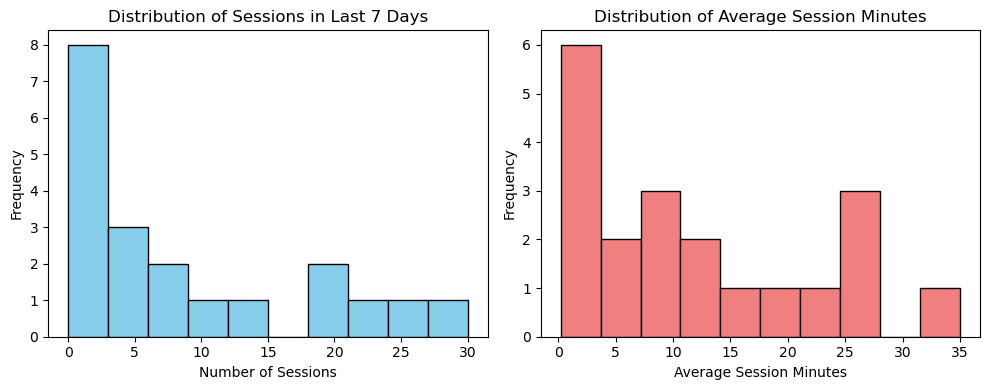

In [33]:
# TODO: pick 2 columns and create 2 plots that reveal something non-trivial
# Example: sessions_last_7d (skew), avg_session_min (heavy tail), tenure_days (range)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# TODO
plt.hist(df['sessions_last_7d'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Sessions in Last 7 Days')
plt.xlabel('Number of Sessions')
plt.ylabel('Frequency')
plt.subplot(1,2,2)
# TODO
plt.hist(df['avg_session_min'], bins=10, color='lightcoral', edgecolor='black')
plt.title('Distribution of Average Session Minutes')
plt.xlabel('Average Session Minutes')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## 3) Target + Slices — 15 minutes


### Task 3.1: Label imbalance


In [37]:
# TODO: compute churn rate and counts
churn_rate = df['churned'].mean()
counts = df['churned'].value_counts()
print(churn_rate)
print(counts)
# Checkpoint: which metric would you choose (accuracy vs F1 vs PR-AUC) and why?
'''
I would choose PR-AUC as the metric because it is more informative for imbalanced datasets.
as it focuses on positive class (Churened in this case) which are often minority class in this type of datasets and often has lower probability of being correctly classified because of imbalances in dataset.
so, it gives a better measure of model performance in such scenarios.
'''

0.3
churned
0    14
1     6
Name: count, dtype: int64


'\nI would choose PR-AUC as the metric because it is more informative for imbalanced datasets.\nas it focuses on positive class (Churened in this case) which are often minority class in this type of datasets and often has lower probability of being correctly classified because of imbalances in dataset.\nso, it gives a better measure of model performance in such scenarios.\n'

### Task 3.2: Slice analysis


In [45]:
# TODO: compute churn rate by country and by plan
by_country = df.groupby('country')['churned'].mean().sort_values(ascending=False)
by_plan = df.groupby('plan')['churned'].mean().sort_values(ascending=False)
print(by_country)
print(by_plan)

# TODO: create a tenure bucket column and compute churn by bucket
# HINT: pd.cut
df2 = df.copy()
df2["tenure_bucket"] = pd.cut(df2["tenure_days"], bins=[-1,14,60,180,10000], labels=['<2 weeks','2 weeks-2 months','2 months-6 months','>6 months'])
by_bucket = df2.groupby('tenure_bucket')['churned'].mean().sort_values(ascending=False)
print(by_bucket)


country
US    0.428571
CA    0.250000
GB    0.250000
IN    0.200000
Name: churned, dtype: float64
plan
basic      0.363636
premium    0.222222
Name: churned, dtype: float64
tenure_bucket
<2 weeks             0.75
2 weeks-2 months     0.50
2 months-6 months    0.20
>6 months            0.00
Name: churned, dtype: float64


C:\Users\jayan\AppData\Local\Temp\ipykernel_44008\2461340005.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_bucket = df2.groupby('tenure_bucket')['churned'].mean().sort_values(ascending=False)


## 4) Leakage + Time — 10 minutes


### Task 4.1: Identify leakage-prone features


In [ ]:
# TODO: identify columns that likely leak label or post-outcome info.
# HINT: refund_after_churn_flag looks suspicious.
leaky_cols = ['refund_after_churn_flag']
leaky_cols

# TODO: write 2-3 sentences explaining why each is leaky (prediction-time availability).
'''
The column 'refund_after_churn_flag' is leaky because it indicates whether a refund was issued after a user churned.
This information would not be available at the time of prediction, as it is determined after the churn event has occurred.
Therefore, using this column in a predictive model would lead to overly optimistic performance estimates, as it provides direct information about the outcome we are trying to predict.
'''


['refund_after_churn_flag']

## 5) Homework — EDA Write-up


In 10–15 bullets:
- Top 5 data issues/risks

in terms of general issues regarding the data would be
    - Missing values
    - Skwed values in datasets
    - Duplications
    - Data type issues
    - inaccuracy (misspelled words, short forms)

- Top 3 features to create next

    - Getting aggregated features
    - Identifying derived features
    - Checking frequency based features

- What you would do before training any model

    - first step would be EDA, then Data cleaning, preprocessing.
    - Thse steps include setting the dtypes, deciding to either fill missing values (if so, how to do it. like using mean or meadian or a default value) or to ommit those data points in traing model.
